In [2]:
import tensorflow as tf
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

### Load data and preprocessing

In [3]:
def load_dataset(path : str) -> pd.DataFrame:
    assert path != "", "The path cannot be empty"
    assert pathlib.Path(path).exists(), "The path does not exist"

    df = pd.read_csv(path, parse_dates=["Date"], date_format="ISO8601", dayfirst=True)
    return df

def filter_by_index(df: pd.DataFrame, index : str, index_label = "Index") -> pd.DataFrame:
    assert index != "", "The index cannot be empty"

    return df.loc[df[index_label] == index]

def filter_after_date(df: pd.DataFrame, date, date_label = "Date") -> pd.DataFrame:
    # assert date != "", "The index cannot be empty"

    return df.loc[df[date_label] > date]

def filter_before_date(df: pd.DataFrame, date, date_label = "Date") -> pd.DataFrame:
    assert date != "", "The index cannot be empty"

    return df.loc[df[date_label] <= date]

def filter_between_date(df: pd.DataFrame, date_low, date_high, date_label = "Date") -> pd.DataFrame:
    new_df =  df.loc[df[date_label] <= date_high]
    return new_df.loc[df[date_label] > date_low]



def remove_nan_rows(df: pd.DataFrame, label):

    assert label != "", "The label cannot be empty"

    return df.dropna()

def select_columns(df : pd.DataFrame, columns : list[str]) -> pd.DataFrame:
    assert len(columns) > 0, "The columns cannot be empty"
    return df.filter(items=columns)

def scale_price(df : pd.DataFrame, price_label : str) -> pd.DataFrame:
    sc = StandardScaler()
    df = df.copy()
    df[price_label] = sc.fit_transform(df[price_label].to_numpy().reshape(-1,1))
    return df

def dataset_to_sequence(timeseries: np.ndarray, timesteps: int) -> tuple[np.ndarray]:
    inputs = []
    outputs = []
    for i in range(len(timeseries) - timesteps):
      intput_serie = []
      if (len(timeseries) - i > timesteps) :  
        for j in range(timesteps):
            intput_serie.append(timeseries[i+j])
            if ( j == timesteps - 1):
              outputs.append(timeseries[i+timesteps])
      inputs.append(np.array(intput_serie).reshape(-1,1))  
    return np.array(inputs), np.array(outputs)

In [4]:
def plot_close_price(X:np.ndarray,Y:np.ndarray, index: str, color='green', scatter = False, filled = False):
    alpha= 0.2
    plt.ylabel('Close Price')
    plt.xlabel('Date')
    plt.title(f'Close price at {index}')
    if (scatter):
        plt.scatter(X,Y, c=color)
        return
    
    if (filled):
        if len(Y.shape) > 1:
            Y = Y.flatten()
        plt.fill_between(X,Y, color=color, alpha=alpha)
    plt.plot(X, Y, color=color)


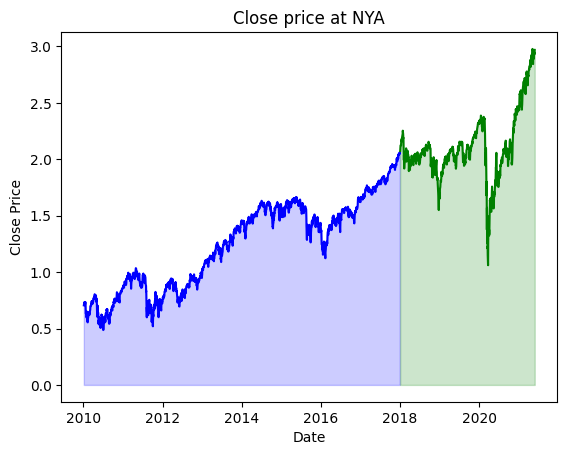

In [33]:
stock_index = "NYA"
price_label = "Close"
time_steps = 30
period = (2010, 2022)
year_train_test_split = 2018

dataset = load_dataset("./dataset/indexData.csv")

nya_dataset = filter_by_index(dataset, stock_index)
nya_close_price = select_columns(nya_dataset, ["Date", price_label, "Index"])
nya_close_price_sc = scale_price(nya_close_price, price_label)
nya_close_price_sc_period = filter_between_date(nya_close_price_sc, str(period[0]), str(period[1]), "Date")
train = filter_before_date(nya_close_price_sc_period, str(year_train_test_split), "Date")
test = filter_after_date(nya_close_price_sc_period, str(year_train_test_split), "Date")

train_clean =  remove_nan_rows(train , price_label)
test_clean =  remove_nan_rows(test, price_label)

X_train, Y_train = dataset_to_sequence(train_clean[price_label].to_numpy(), time_steps)
X_test, Y_test = dataset_to_sequence(test_clean[price_label].to_numpy(), time_steps)

plot_close_price(train["Date"].to_numpy(), train[price_label].to_numpy(), index=stock_index, color="blue", filled=True)
plot_close_price(test["Date"].to_numpy(), test[price_label].to_numpy(), index=stock_index, color="green", filled=True)


### LSTM-Autoencoder Model

In [7]:
from tensorflow.keras.layers import LSTM, Dense, Dropout,  TimeDistributed, RepeatVector 

lstm_units = 128

autoencoder_lstm_model = tf.keras.Sequential()
# Encoder
autoencoder_lstm_model.add(LSTM(lstm_units, activation='relu', input_shape = (X_train.shape[1], X_train.shape[2])))
autoencoder_lstm_model.add(Dropout(0.2))
# Bridge
autoencoder_lstm_model.add(RepeatVector(X_train.shape[1]))

autoencoder_lstm_model.add(LSTM(lstm_units, activation='relu', return_sequences=True))
autoencoder_lstm_model.add(Dropout(0.2))
autoencoder_lstm_model.add(TimeDistributed(Dense(X_train.shape[2])))
autoencoder_lstm_model.compile(optimizer="adam", loss="mse")
autoencoder_lstm_model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 128)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             129       
 ributed)                                             

In [8]:
history_autoencoder_lstm_model = autoencoder_lstm_model.fit(X_train, Y_train, epochs=20, verbose=True, validation_split=0.05, shuffle=False)

Epoch 1/20

59/59 [==============================] - 8s 44ms/step - loss: 0.1251 - val_loss: 0.0454
Epoch 2/20
59/59 [==============================] - 2s 36ms/step - loss: 0.0346 - val_loss: 0.0057
Epoch 3/20
59/59 [==============================] - 2s 37ms/step - loss: 0.0295 - val_loss: 0.0063
Epoch 4/20
59/59 [==============================] - 2s 42ms/step - loss: 0.0294 - val_loss: 0.0366
Epoch 5/20
59/59 [==============================] - 2s 41ms/step - loss: 0.0289 - val_loss: 0.0136
Epoch 6/20
59/59 [==============================] - 2s 37ms/step - loss: 0.0400 - val_loss: 0.0143
Epoch 7/20
59/59 [==============================] - 2s 37ms/step - loss: 0.0633 - val_loss: 0.0033
Epoch 8/20
59/59 [==============================] - 2s 38ms/step - loss: 0.0719 - val_loss: 0.0264
Epoch 9/20
59/59 [==============================] - 2s 33ms/step - loss: 0.0803 - val_loss: 0.0506
Epoch 10/20
59/59 [==============================] - 2s 36ms/step - loss: 0.0728 - val_loss: 0.0842
Epoch 11

### Autoencoder

In [9]:

from tensorflow.keras.layers import LSTM, Dense, Dropout,  TimeDistributed, RepeatVector 

n_hidden_encoder = 16
n_bottleneck = 8

autoencoder_model = tf.keras.Sequential([
    Dense(n_hidden_encoder, input_shape=(X_train.shape[1],), activation="relu"),
    Dense(n_bottleneck, activation="relu"),
    Dense(n_hidden_encoder, activation="relu"),
    Dense(X_train.shape[1], activation="linear"),
])

autoencoder_model.compile(
    optimizer = "adam",
    loss="mse"
)

autoencoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16)                496       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 30)                510       
                                                                 
Total params: 1286 (5.02 KB)
Trainable params: 1286 (5.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
history_autoencoder = autoencoder_model.fit(X_train, Y_train, epochs=20, verbose=True, validation_split=0.05, shuffle=False)

Epoch 1/20
59/59 [==============================] - 2s 9ms/step - loss: 0.8730 - val_loss: 1.2677
Epoch 2/20
59/59 [==============================] - 0s 4ms/step - loss: 0.2791 - val_loss: 0.3009
Epoch 3/20
59/59 [==============================] - 0s 4ms/step - loss: 0.0467 - val_loss: 0.0373
Epoch 4/20
59/59 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0054
Epoch 5/20
59/59 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0025
Epoch 6/20
59/59 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0021
Epoch 7/20
59/59 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0020
Epoch 8/20
59/59 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 9/20
59/59 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 10/20
59/59 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 11/20
59/59 [

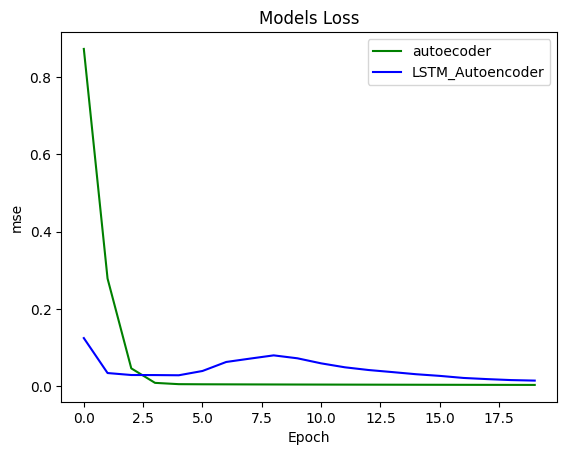

In [11]:
def plot_every_trainig_loss(history_models_loss: list, colors = [], labels=[], loss_function="mse"):

    plt.title("Models Loss")
    plt.ylabel(loss_function)
    plt.xlabel("Epoch")
    for i, history in enumerate(history_models_loss):
        plt.plot(history, c=colors[i], label= labels[i]) 
        plt.legend()


plot_every_trainig_loss([history_autoencoder.history["loss"], history_autoencoder_lstm_model.history["loss"]], ["green", "blue"], ["autoecoder", "LSTM_Autoencoder"])

### Select a threshold

62/62 [==============================] - 0s 3ms/step
Threshold by autoencoder 0.12468053790743469
Threshold by autoencoder lstm  0.19062992565601275


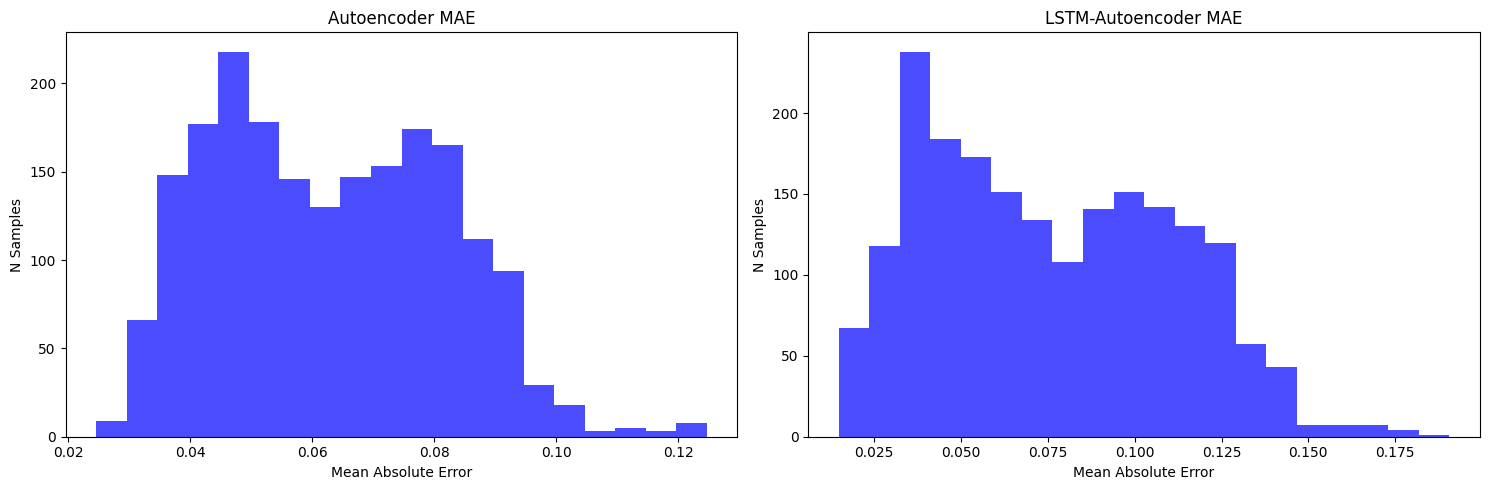

In [12]:



Y_train_autoencoder_lstm_pred = autoencoder_lstm_model.predict(X_train)
Y_train_autoencoder_pred = np.reshape(autoencoder_model.predict(X_train), X_train.shape)

train_mae_loss_autoencoder_lstm = np.mean(np.abs(Y_train_autoencoder_lstm_pred - X_train), axis=1)
train_mae_loss_autoencoder = np.mean(np.abs(Y_train_autoencoder_pred - X_train), axis=1)

def plot_n_samples_error_model(errors_list, titles):

    num_plots = len(errors_list)
    _, axes = plt.subplots(1, num_plots, figsize=(15, 5))

    for i in range(num_plots):
        axes[i].hist(errors_list[i], bins=20, alpha=0.7, color='blue')
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Mean Absolute Error')
        axes[i].set_ylabel('N Samples')

    plt.tight_layout()
    plt.show()


threshold_autoencoder = np.max(train_mae_loss_autoencoder) 
threshold_autoencoder_lstm = np.max(train_mae_loss_autoencoder_lstm) 
print("Threshold by autoencoder", threshold_autoencoder)
print("Threshold by autoencoder lstm ", threshold_autoencoder_lstm)

plot_n_samples_error_model([train_mae_loss_autoencoder, train_mae_loss_autoencoder_lstm], ["Autoencoder MAE", "LSTM-Autoencoder MAE"])



### Detect Anomalies on Test Data

26/26 [==============================] - 0s 1ms/step


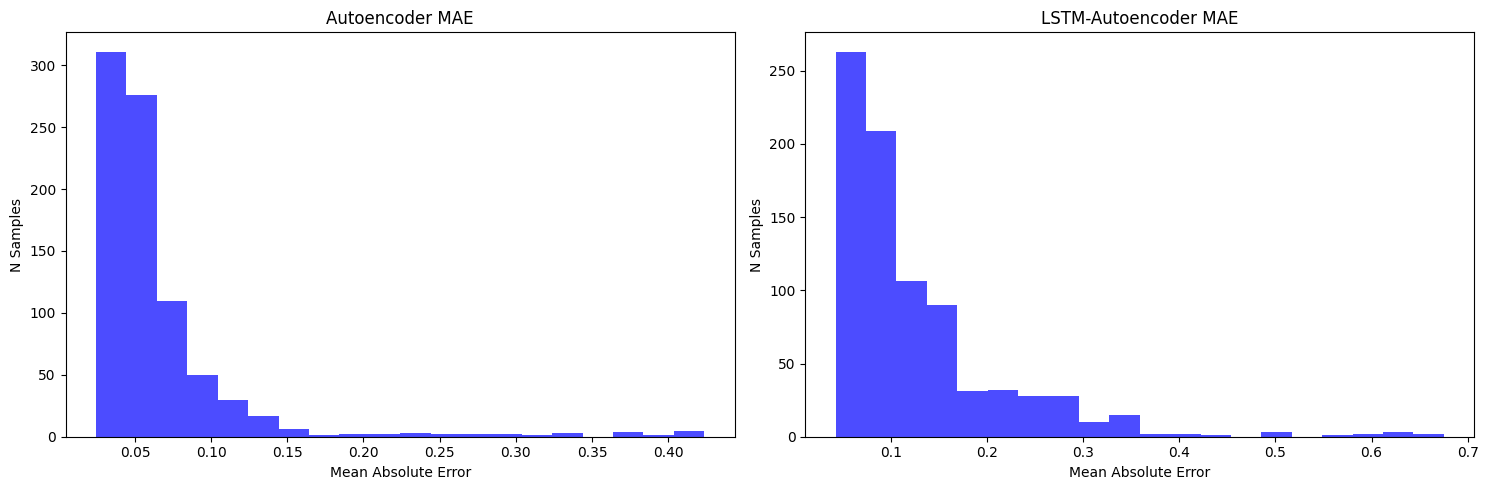

In [13]:

Y_test_pred_autoencoder_lstm_pred = autoencoder_lstm_model.predict(X_test)
Y_test_pred_autoencoder_pred = np.reshape(autoencoder_model.predict(X_test), X_test.shape)

test_mae_loss_autoencoder_lstm = np.mean(np.abs(Y_test_pred_autoencoder_lstm_pred - X_test), axis=1)
test_mae_loss_autoencoder = np.mean(np.abs(Y_test_pred_autoencoder_pred - X_test), axis=1)

plot_n_samples_error_model([test_mae_loss_autoencoder, test_mae_loss_autoencoder_lstm], ["Autoencoder MAE", "LSTM-Autoencoder MAE"])


In [17]:


# Probamos despues de los primeros 30 dias
test_df = pd.DataFrame(test_clean[time_steps:], )

test_df.index = range(len(test_df))


test_df["loss_autoencoder_lstm"] = pd.Series(test_mae_loss_autoencoder_lstm.flatten())
test_df["loss_autoencoder"] = pd.Series(test_mae_loss_autoencoder.flatten())

test_df["threshold_autoencoder_lstm"] = threshold_autoencoder_lstm
test_df["threshold_autoencoder"] = threshold_autoencoder

test_df["anomaly_autoencoder_lstm"] = test_df["loss_autoencoder_lstm"] > test_df["threshold_autoencoder_lstm"]
test_df["anomaly_autoencoder"] = test_df["loss_autoencoder"] > test_df["threshold_autoencoder"]

test_df




,Date,Close,Index,loss_autoencoder_lstm,loss_autoencoder,threshold_autoencoder_lstm,threshold_autoencoder,anomaly_autoencoder_lstm,anomaly_autoencoder
0,2018-02-14,2.035315,NYA,0.189732,0.075229,0.19063,0.124681,False,False
1,2018-02-15,2.062343,NYA,0.177267,0.078519,0.19063,0.124681,False,False
2,2018-02-16,2.066635,NYA,0.163543,0.079190,0.19063,0.124681,False,False
3,2018-02-20,2.039393,NYA,0.152458,0.083181,0.19063,0.124681,False,False
4,2018-02-21,2.022754,NYA,0.149326,0.090370,0.19063,0.124681,False,False
...,...,...,...,...,...,...,...,...,...
823,2021-05-24,2.947630,NYA,0.355000,0.047034,0.19063,0.124681,True,False
824,2021-05-25,2.929349,NYA,0.352052,0.046403,0.19063,0.124681,True,False
825,2021-05-26,2.944506,NYA,0.353906,0.041046,0.19063,0.124681,True,False
826,2021-05-27,2.964134,NYA,0.353999,0.042250,0.19063,0.124681,True,False


### LSTM-Autoencoder vs Autoencoder

Number of anomalies (LSTM_autoencoder) 266
Number of anomalies (autoencoder) 102


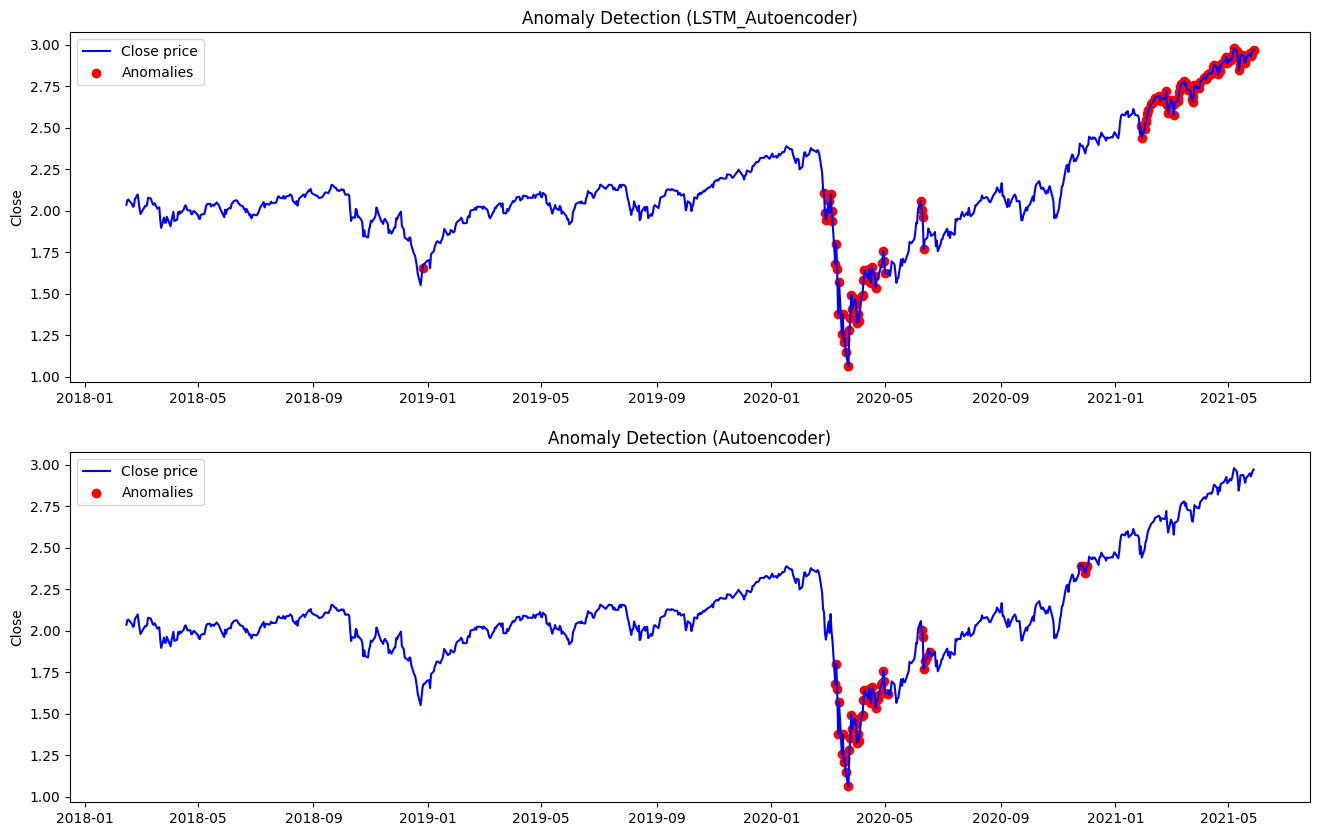

In [ ]:
autoencoder_lstm_anomalies_df = test_df[["Date", "Close"]].loc[test_df["anomaly_autoencoder_lstm"] == True]
autoencoder_anomalies_df = test_df[["Date", "Close"]].loc[test_df["anomaly_autoencoder"] == True]

_, axes = plt.subplots(2, 1, figsize=(16, 10))

axes[0].set_title(f"Anomaly Detection (LSTM_Autoencoder): {autoencoder_lstm_anomalies_df.size} anomalies")
axes[0].plot(test_df["Date"],test_df["Close"], color='blue', label="Close price")
axes[0].scatter(autoencoder_lstm_anomalies_df["Date"], autoencoder_lstm_anomalies_df["Close"], c="red", label = "Anomalies")
axes[0].set_ylabel("Close")
axes[0].legend()

axes[1].set_title(f"Anomaly Detection (Autoencoder): {autoencoder_lstm_anomalies_df.size} anomalies")
axes[1].plot(test_df["Date"],test_df["Close"], color='blue', label="Close price")
axes[1].scatter(autoencoder_anomalies_df["Date"], autoencoder_anomalies_df["Close"], c="red", label = "Anomalies")
axes[1].set_ylabel("Close")
axes[1].legend()

print("Number of anomalies (LSTM_autoencoder)", autoencoder_lstm_anomalies_df.size)
print("Number of anomalies (autoencoder)", autoencoder_anomalies_df.size)